```{index} disjunctive programming
```
```{index} single: application; scheduling
```
```{index} single: solver; HiGHS
```
```{index} single: Gantt charts
```
```{index} pandas dataframe
```
# 3.5 Machine Scheduling

## Preamble: Install Pyomo and a solver

The following cell sets and verifies a global SOLVER for the notebook. If run on Google Colab, the cell installs Pyomo and the HiGHS solver, while, if run elsewhere, it assumes Pyomo and HiGHS have been previously installed. It then sets to use HiGHS as solver via the appsi module and a test is performed to verify that it is available. The solver interface is stored in a global object `SOLVER` for later use.

In [1]:
import sys
 
if 'google.colab' in sys.modules:
    %pip install pyomo >/dev/null 2>/dev/null
    %pip install highspy >/dev/null 2>/dev/null
 
solver = 'appsi_highs'
 
import pyomo.environ as pyo
SOLVER = pyo.SolverFactory(solver)

assert SOLVER.available(), f"Solver {solver} is not available."

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

## Problem description

"Which job should be done next?" is a question one face in modern life, whether for a busy student working on course assignments, a courier delivering packages, a server waiting on tables in a busy restaurant, a computer processing threads, or a machine on a complex assembly line. There are well-known empirical rules or heuristics to address to this question, among which "first in, first out", "last in, first out", or "shortest job first".  

What we consider in this notebook is the modeling finding solutions to this class of problem using optimization techniques. This notebook demonstrates the formulation of a model for scheduling a single machine scheduling using disjunctive programming in Pyomo. Data for the example problem is from Chapter 5 of the book by Christelle Gueret, Christian Prins, Marc Sevaux titled [Applications of Optimization with Xpress-MP](https://www2.isye.gatech.edu/~sahmed/isye3133b/XpressBook.pdf) (Dash Optimization, 2000).

Consider the problem of scheduling a set of jobs on a single machine given the release time, duration, and due time for each job. Our goal is to find a sequence of the jobs on the machine that meets the due dates. If no such schedule exists, then the objective is to find the least bad schedule that minimizes a designated performance metric. 

### Job data

The data is given as a Pandas dataframe in which each row corresponds to a job, its release time, duration, and due date. 

In [3]:
jobs = pd.DataFrame(
    {
        "A": {"release": 2, "duration": 5, "due": 10},
        "B": {"release": 5, "duration": 6, "due": 21},
        "C": {"release": 4, "duration": 8, "due": 15},
        "D": {"release": 0, "duration": 4, "due": 10},
        "E": {"release": 0, "duration": 2, "due": 5},
        "F": {"release": 8, "duration": 3, "due": 15},
        "G": {"release": 9, "duration": 2, "due": 22},
    }
).T
display(jobs)

,release,duration,due
A,2,5,10
B,5,6,21
C,4,8,15
D,0,4,10
E,0,2,5
F,8,3,15
G,9,2,22


### Schedule data

A schedule is also represented here by a Pandas dataframe indexed by job names. The columns indicate the start, finish, and the amount by each job is past due. The following function creates the schedule corresponding to the scenario in which jobs are executed in the order given by the `jobs` dataframe.

In [4]:
def schedule_jobs(jobs, seq):
    schedule = pd.DataFrame(index=jobs.index)
    t = 0
    for job in seq:
        t = max(t, jobs.loc[job]["release"])
        schedule.loc[job, "start"] = t
        t += jobs.loc[job, "duration"]
        schedule.loc[job, "finish"] = t
        schedule.loc[job, "past"] = max(0, t - jobs.loc[job, "due"])

    return schedule


schedule = schedule_jobs(jobs, jobs.index)
schedule

,start,finish,past
A,2.0,7.0,0.0
B,7.0,13.0,0.0
C,13.0,21.0,6.0
D,21.0,25.0,15.0
E,25.0,27.0,22.0
F,27.0,30.0,15.0
G,30.0,32.0,10.0


### Gantt chart

A classical way of visualizing scheduling data in the form of a Gantt chart. The next cell defines a function `gantt` that plots a Gantt chart given jobs and schedule information. 

Using the "job order" strategy, the total past due is 68.0


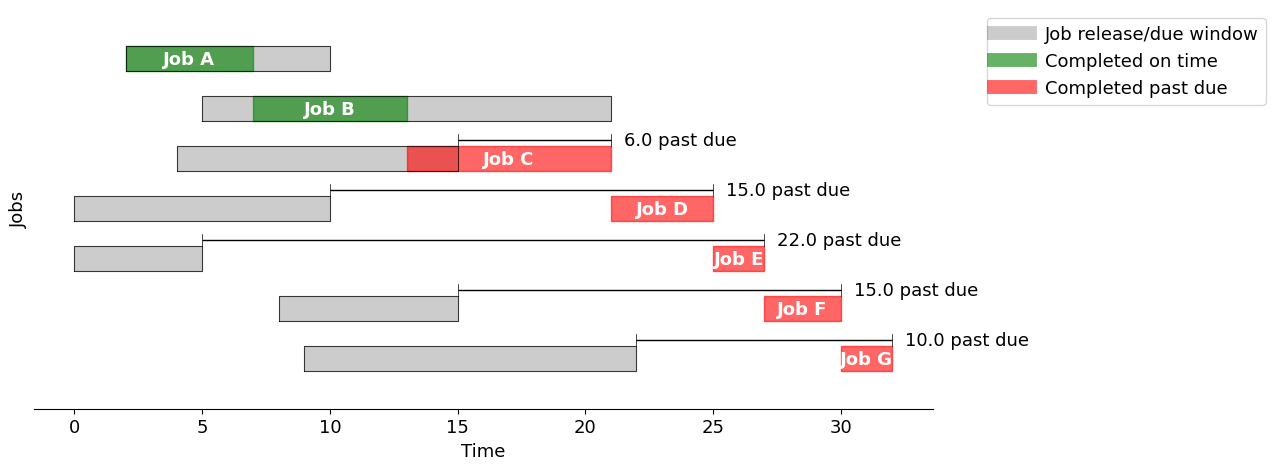

In [5]:
def gantt(jobs, schedule, title=""):
    w = 0.25  # bar width

    plt.rcParams.update({"font.size": 13})
    fig, ax = plt.subplots(1, 1, figsize=(13, 0.7 * len(jobs.index)))

    for k, job in enumerate(jobs.index):
        r = jobs.loc[job, "release"]
        d = jobs.loc[job, "due"]
        s = schedule.loc[job, "start"]
        f = schedule.loc[job, "finish"]

        # Show job release-due window
        ax.fill_between(
            [r, d], [-k - w, -k - w], [-k + w, -k + w], lw=1, color="k", alpha=0.2
        )
        ax.plot(
            [r, r, d, d, r], [-k - w, -k + w, -k + w, -k - w, -k - w], lw=0.5, color="k"
        )

        # Show job start-finish window
        color = "g" if f <= d else "r"
        ax.fill_between(
            [s, f], [-k - w, -k - w], [-k + w, -k + w], color=color, alpha=0.6
        )
        ax.text(
            (s + f) / 2.0,
            -k,
            "Job " + job,
            color="white",
            weight="bold",
            ha="center",
            va="center",
        )

        # If past due
        if f > d:
            ax.plot([d] * 2, [-k + w, -k + 2 * w], lw=0.5, color="k")
            ax.plot([f] * 2, [-k + w, -k + 2 * w], lw=0.5, color="k")
            ax.plot([d, f], [-k + 1.5 * w] * 2, solid_capstyle="butt", lw=1, color="k")
            ax.text(
                f + 0.5,
                -k + 1.5 * w,
                f"{schedule.loc[job, 'past']} past due",
                va="center",
            )

    total_past_due = schedule["past"].sum()
    ax.set_ylim(-len(jobs.index), 1)
    print(f'Using the "{title}" strategy, the total past due is {total_past_due}')
    ax.set_xlabel("Time")
    ax.set_ylabel("Jobs")
    ax.set_yticks([])
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)

    custom_lines = [
        Line2D([0], [0], c="k", lw=10, alpha=0.2),
        Line2D([0], [0], c="g", lw=10, alpha=0.6),
        Line2D([0], [0], c="r", lw=10, alpha=0.6),
    ]
    ax.legend(
        custom_lines,
        ["Job release/due window", "Completed on time", "Completed past due"],
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
    )

    plt.tight_layout()
    plt.show()


gantt(jobs, schedule, "job order")

## Empirical Scheduling Rules

To provide a comparison to scheduling using a MILO model, we first implement three well-known and accepted empirical rules for scheduling jobs on a single machine:

* First in, first out (FIFO)
* Earliest due data (EDD)
* Shortest processing time (SPT)

### First-in, first-out (FIFO)

One of the most common scheduling rules is to execute jobs in the order they are released for processing, in other words "first-in, first-out" (FIFO). The following cell creates a Pandas dataframe  is indexed by job names. The start time, finish time, and, if past due, the amount by which the job is past due.


Using the "First in, First out" strategy, the total past due is 31.0


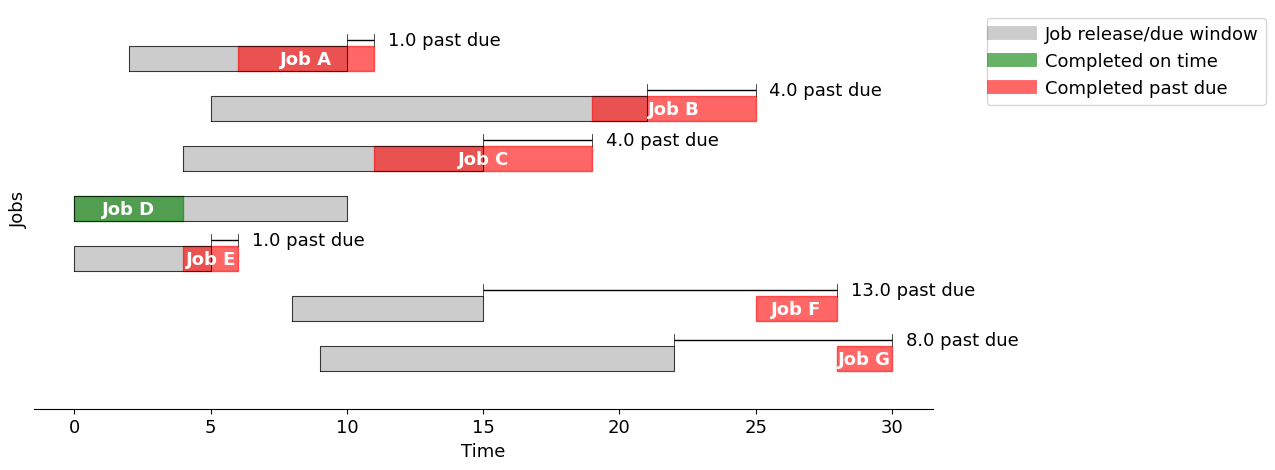

In [6]:
fifo = schedule_jobs(jobs, jobs.sort_values(by="release").index)
gantt(jobs, fifo, "First in, First out")

### Earliest due date (EDD)

When due dates are known, a common scheduling rule is to prioritize jobs by due date. This strategy will be familiar to any student deciding which homework assignment should to work on next.

Using the "Earliest due date" strategy, the total past due is 27.0


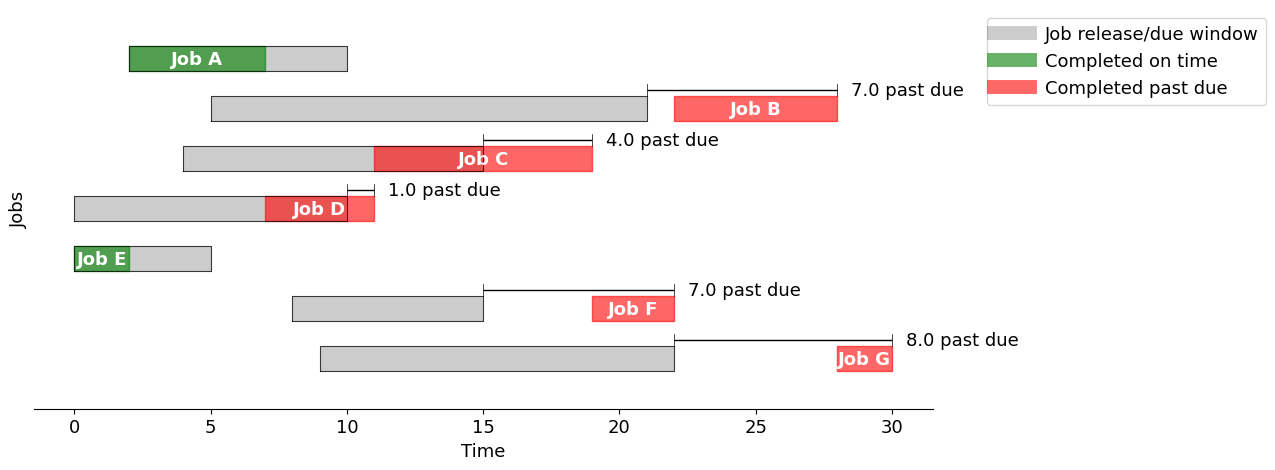

In [7]:
edd = schedule_jobs(jobs, jobs.sort_values(by="due").index)
gantt(jobs, edd, "Earliest due date")

### Shortest processing time (SPT)

When the job durations are known, another common scheduling rule is to prioritize jobs by their (remaining) processing time.

Using the "Shortest Processing Time" strategy, the total past due is 51.0


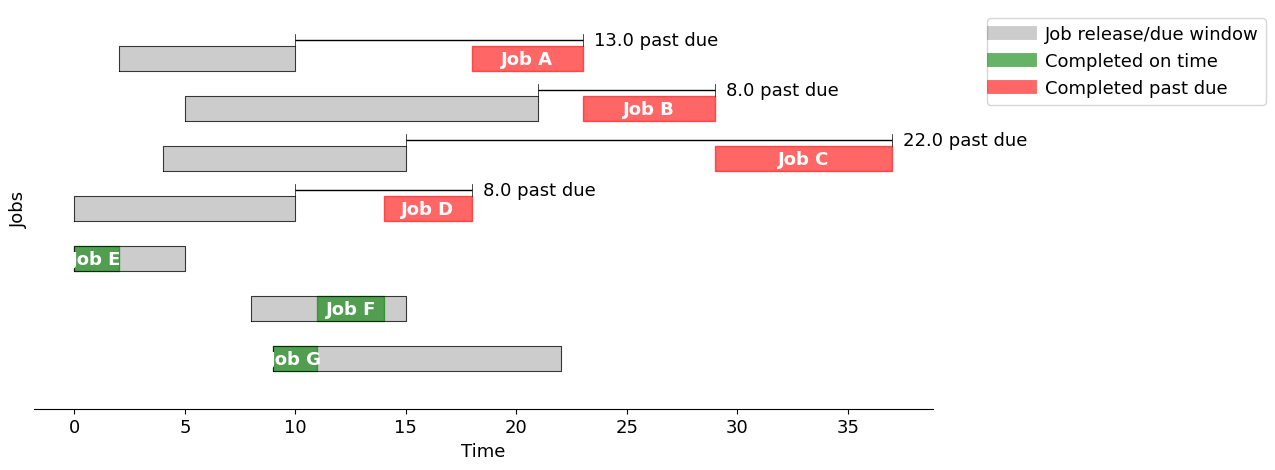

In [8]:
spt = schedule_jobs(jobs, jobs.sort_values(by="duration").index)
gantt(jobs, spt, "Shortest Processing Time")

## Optimal scheduling using disjunctive programming

The modeling starts by defining the problem data.

<div align="center">

| Symbol | Description 
|:---- | :--- 
| $\text{release}_j$ | when job $j$ is available
| $\text{duration}_j$ | how long job $j$ takes
| $\text{due}_j$ | when job $j$ is due 

</div>

The essential decision variables are the times at which each job starts processing, but it is convenient to add auxiliary variables defining the times at which each job finishes and the amount by which each job is past due.

<div align="center">

| Symbol | Description
|:---- | :--- 
| $\text{start}_j$ | when job $j$ starts
| $\text{finish}_j$ | when job $j$ finishes
| $\text{past}_j$ | how long job $j$ is past due

</div>

Depending on application and circumstances, various objectives can be considered. Suitable objectives include the total number of late jobs, the longest past due interval, or the sum of all past due intervals. We consider an optimization problem that minimizes the sum of past due intervals, that is

$$
\min \sum_j \text{past}_j
$$

Constraints describe the required logical relationships among the decision variables. For example, a job cannot start until it is released for processing

$$
\begin{align*}
\text{start}_{j} & \geq \text{release}_{j}\\
\end{align*}
$$

Once started, machine processing continues until the job is finished. The finish time for each job is compared to the due time, and any past due interval is stored the $\text{past}_j$ decision variable. 

$$
\begin{align*}
\text{finish}_j & = \text{start}_j + \text{duration}_j \\
\text{past}_{j} & \geq \text{finish}_j - \text{due}_{j} \\
\text{past}_{j} & \geq 0
\end{align*}
$$

The final set of constraints require that no pair of jobs be operating on the same machine at the same time. For this purpose, we consider each unique pair ($i$, $j$) where the constraint $i < j$ to imposed to avoid considering the same pair twice. Then for any unique pair $i$ and $j$,  either $i$ finishes before $j$ starts, or $j$ finishes before $i$ starts. This is expressed as the family of disjunctions 

$$
\begin{align*}
\begin{bmatrix}
\text{finish}_i \leq \text{start}_j
\end{bmatrix}
& \veebar
\begin{bmatrix}
\text{finish}_j \leq \text{start}_i
\end{bmatrix}
& \forall i < j
\end{align*}
$$

This model and constraints can be directly translated to Pyomo using the Disjuction component as follows.

,start,finish,past
A,2.0,7.0,0.0
B,14.0,20.0,0.0
C,22.0,30.0,15.0
D,7.0,11.0,1.0
E,0.0,2.0,0.0
F,11.0,14.0,0.0
G,20.0,22.0,0.0


Using the "Minimize total past due" strategy, the total past due is 16.0


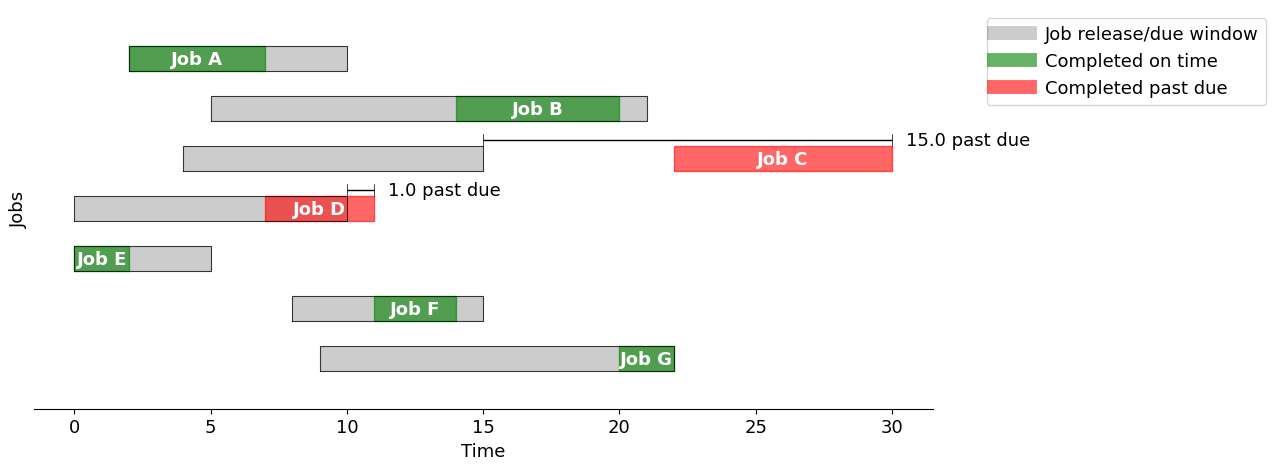

In [9]:
def machine_schedule(jobs):
    m = pyo.ConcreteModel("Job machine scheduling")

    # Create a set of jobs using the dataframe index and a
    # set of orderd pairs of distinct jobs (i,j) with i < j
    m.JOBS = pyo.Set(initialize=jobs.index)
    m.PAIRS = pyo.Set(initialize=m.JOBS * m.JOBS, filter=lambda m, i, j: i < j)

    # We set an upper bound on the time horizon to 100
    m.maxtime = pyo.Param(initialize=100)
    m.start = pyo.Var(m.JOBS, domain=pyo.NonNegativeReals, bounds=(0, m.maxtime))
    m.finish = pyo.Var(m.JOBS, domain=pyo.NonNegativeReals, bounds=(0, m.maxtime))
    m.past = pyo.Var(m.JOBS, domain=pyo.NonNegativeReals, bounds=(0, m.maxtime))

    @m.Constraint(m.JOBS)
    def job_release(m, job):
        return m.start[job] >= jobs.loc[job, "release"]

    @m.Constraint(m.JOBS)
    def job_duration(m, job):
        return m.finish[job] == m.start[job] + jobs.loc[job, "duration"]

    @m.Constraint(m.JOBS)
    def past_due_constraint(m, job):
        return m.past[job] >= m.finish[job] - jobs.loc[job, "due"]

    @m.Disjunction(m.PAIRS, xor=True)
    def machine_deconflict(m, job_a, job_b):
        return [m.finish[job_a] <= m.start[job_b], m.finish[job_b] <= m.start[job_a]]

    @m.Objective(sense=pyo.minimize)
    def minimize_past(m):
        return sum(m.past[job] for job in m.JOBS)

    return m


m = machine_schedule(jobs)
pyo.TransformationFactory("gdp.bigm").apply_to(m)
SOLVER.solve(m)

optimalschedule = pd.DataFrame(
    {
        "start": m.start.extract_values(),
        "finish": m.finish.extract_values(),
        "past": m.past.extract_values(),
    }
)

display(optimalschedule)
gantt(jobs, optimalschedule, "Minimize total past due")

The solution obtained solving the optimization problem outperforms that derived from any of the rules outline above. Nonetheless, heuristic techniques become essential when tackling large scheduling problems.

For comparison, we also implement a standard MILO using the big-M method. The idea is to introduce a binary variable $z_{ij} \in \{0,1\}$ for each disjunctive constraint above.

$$
\begin{align*}
\textup{finish}_i & \leq  \textup{start}_j + M z_{ij} \\
\textup{finish}_j & \leq  \textup{start}_i + M (1 - z_{ij}).
\end{align*}
$$

This creates an equivalent MILO model which leads to the same solution, but it features many more variables and is usually slower to solve.

,start,finish,past
A,6.0,11.0,1.0
B,14.0,20.0,0.0
C,22.0,30.0,15.0
D,2.0,6.0,0.0
E,0.0,2.0,0.0
F,11.0,14.0,0.0
G,20.0,22.0,0.0


Using the "Minimize total past due" strategy, the total past due is 16.0


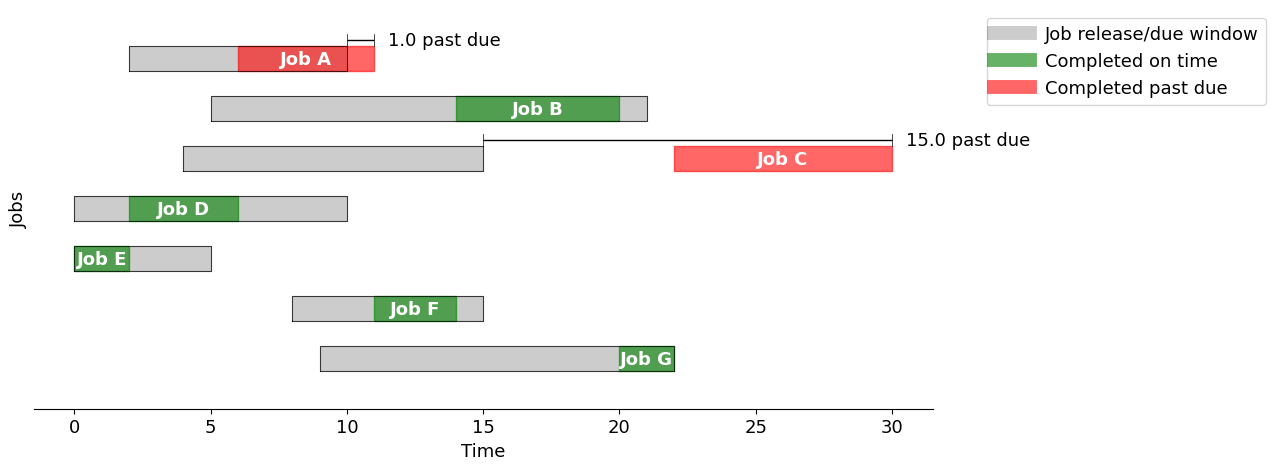

In [10]:
def machine_scheduleMILO(jobs):
    m = pyo.ConcreteModel("Job machine scheduling using MILO formulation")

    m.JOBS = pyo.Set(initialize=jobs.index)
    m.PAIRS = pyo.Set(initialize=m.JOBS * m.JOBS, filter=lambda m, i, j: i < j)

    m.maxtime = pyo.Param(initialize=100)
    m.start = pyo.Var(m.JOBS, domain=pyo.NonNegativeReals, bounds=(0, m.maxtime))
    m.finish = pyo.Var(m.JOBS, domain=pyo.NonNegativeReals, bounds=(0, m.maxtime))
    m.past = pyo.Var(m.JOBS, domain=pyo.NonNegativeReals, bounds=(0, m.maxtime))

    # Auxiliary binary variables to linearize the disjunction using the big-M approach
    m.z = pyo.Var(m.PAIRS, domain=pyo.Binary)
    m.bigM = pyo.Param(initialize=10000)

    @m.Constraint(m.JOBS)
    def job_release(m, job):
        return m.start[job] >= jobs.loc[job, "release"]

    @m.Constraint(m.JOBS)
    def job_duration(m, job):
        return m.finish[job] == m.start[job] + jobs.loc[job, "duration"]

    @m.Constraint(m.JOBS)
    def past_due_constraint(m, job):
        return m.past[job] >= m.finish[job] - jobs.loc[job, "due"]

    @m.Constraint(m.PAIRS)
    def machine_deconflict_a(m, job_a, job_b):
        return m.finish[job_a] <= m.start[job_b] + m.bigM * (1 - m.z[job_a, job_b])

    @m.Constraint(m.PAIRS)
    def machine_deconflict_b(m, job_a, job_b):
        return m.finish[job_b] <= m.start[job_a] + m.bigM * m.z[job_a, job_b]

    @m.Objective(sense=pyo.minimize)
    def minimize_past(m):
        return sum(m.past[job] for job in m.JOBS)

    SOLVER.solve(m)

    return m


m = machine_scheduleMILO(jobs)

optimalschedule_MILO = pd.DataFrame(
    {
        "start": m.start.extract_values(),
        "finish": m.finish.extract_values(),
        "past": m.past.extract_values(),
    }
)

display(optimalschedule_MILO)
gantt(jobs, optimalschedule_MILO, "Minimize total past due")